In [2]:
import ee

In [3]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
import ee, datetime
import pandas as pd
import geopandas as gpd
import matplotlib.dates as mdates
from IPython.display import Image
from matplotlib import dates
from shapely.geometry import shape
import skimage

In [12]:
import ee
import folium

# Google Earth Engine 초기화
ee.Initialize()

# 주어진 GeoJSON 영역
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              126.19653266055587,
              36.853168924185226
            ],
            [
              126.19653266055587,
              36.83836240145186
            ],
            [
              126.21259510596076,
              36.83836240145186
            ],
            [
              126.21259510596076,
              36.853168924185226
            ],
            [
              126.19653266055587,
              36.853168924185226
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
# 기간 설정 및 Sentinel-1 데이터 가져오기
start_date = '2017-01-01'
end_date = '2023-03-31'

# AOI 설정
aoi = ee.Geometry.Polygon(geojson['features'][0]['geometry']['coordinates'])

# Create an ImageCollection for a specific date range, area, and parameters.
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('instrumentMode', 'IW'))
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')))

def add_rvi(image):
    # RVI 계산
    rvi = image.expression(
        '4 * float(VV) / (VV + VH) ** 2',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('RVI')

    # RVI 밴드 추가
    return image.addBands(rvi)

# NDVI 및 변화 추가
with_rvi_collection = collection.map(add_rvi)

In [13]:
import pandas as pd
import pandas as pd
from tqdm import tqdm



In [14]:
first_image = with_rvi_collection.first()
print(first_image.bandNames())

ee.List({
  "functionInvocationValue": {
    "functionName": "Image.bandNames",
    "arguments": {
      "image": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.map",
                "arguments": {
                  "baseAlgorithm": {
                    "functionDefinitionValue": {
                      "argumentNames": [
                        "_MAPPING_VAR_0_0"
                      ],
                      "body": {
                        "functionInvocationValue": {
                          "functionName": "Image.addBands",
                          "arguments": {
                            "dstImg": {
                              "argumentReference": "_MAPPING_VAR_0_0"
                            },
                            "srcImg": {
                              "functionInvocationValue": {
   

In [15]:

# AOI 내의 모든 이미지에 대해 반복하면서 평균값을 계산합니다.
for i in tqdm(range(image_list.size().getInfo())):
    # 이미지를 가져옵니다.
    image = ee.Image(image_list.get(i))
    # 이미지 촬영 날짜를 가져옵니다.
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    # NDVI 밴드의 AOI 영역에 대한 평균값을 계산합니다.
    mean_rvi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10  # 여기서 scale을 원하는 해상도로 설정하세요
    ).get('RVI').getInfo()  # 'NDVI' 대신 사용하고 있는 밴드의 이름을 사용하세요.

    # 날짜와 평균 NDVI 값을 데이터 리스트에 추가합니다.
    data.append({
        'ds': date,
        'y': mean_rvi
    })

# 데이터를 Pandas 데이터프레임으로 변환
df = pd.DataFrame(data)

# 결과 확인
print(df)

100%|██████████| 224/224 [13:28<00:00,  3.61s/it]

             ds         y
0    2017-02-24 -0.055644
1    2017-03-08 -0.054415
2    2017-03-20 -0.054320
3    2017-04-01 -0.053906
4    2017-04-13 -0.054767
..          ...       ...
219  2018-08-24 -0.057910
220  2019-09-05 -0.060428
221  2020-08-18 -0.059849
222  2020-08-25 -0.059215
223  2020-08-30 -0.062199

[224 rows x 2 columns]


In [16]:
from prophet import Prophet
# Prophet 모델을 초기화하고 학습시킵니다.
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(df)

# 미래 날짜 프레임을 만들고 예측을 진행합니다.
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future) 

# 예측 결과를 가져옵니다.
forecasted_value = forecast.iloc[-1]['yhat']  # 예측된 값을 가져옴
print(f"Forecasted mean NDVI for the next period: {forecasted_value}")

# 예측 결과를 데이터프레임에 추가합니다.
forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)


19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing


Forecasted mean NDVI for the next period: -0.057909596270360957
                      ds         y
220           2019-09-05 -0.060428
221           2020-08-18 -0.059849
222           2020-08-25 -0.059215
223           2020-08-30 -0.062199
224  2024-03-24 00:00:00 -0.057910


C:\Users\gunwo\AppData\Local\Temp\ipykernel_26104\2111206558.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)


In [17]:
import pandas as pd
from prophet import Prophet
import plotly.offline as py

In [18]:
fig = plot_plotly(m,forecast)

NameError: name 'plot_plotly' is not defined

In [82]:
fig.show()

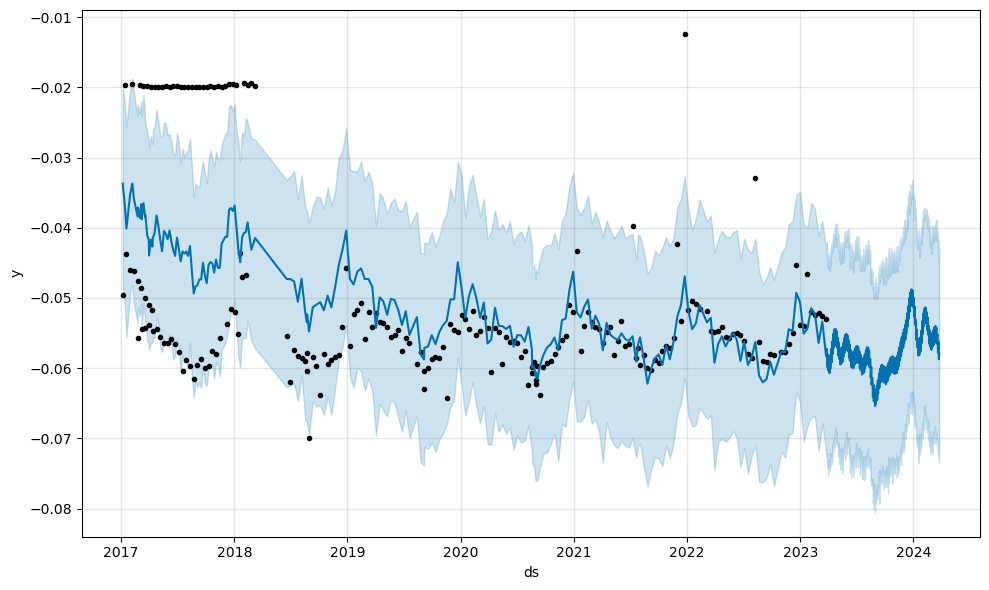

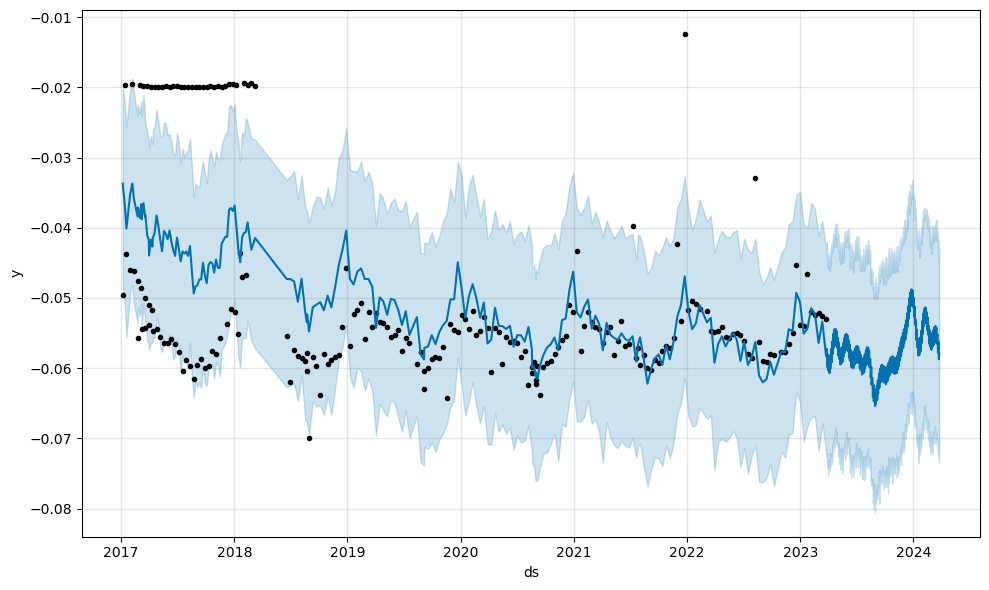

In [19]:
m.plot(forecast)

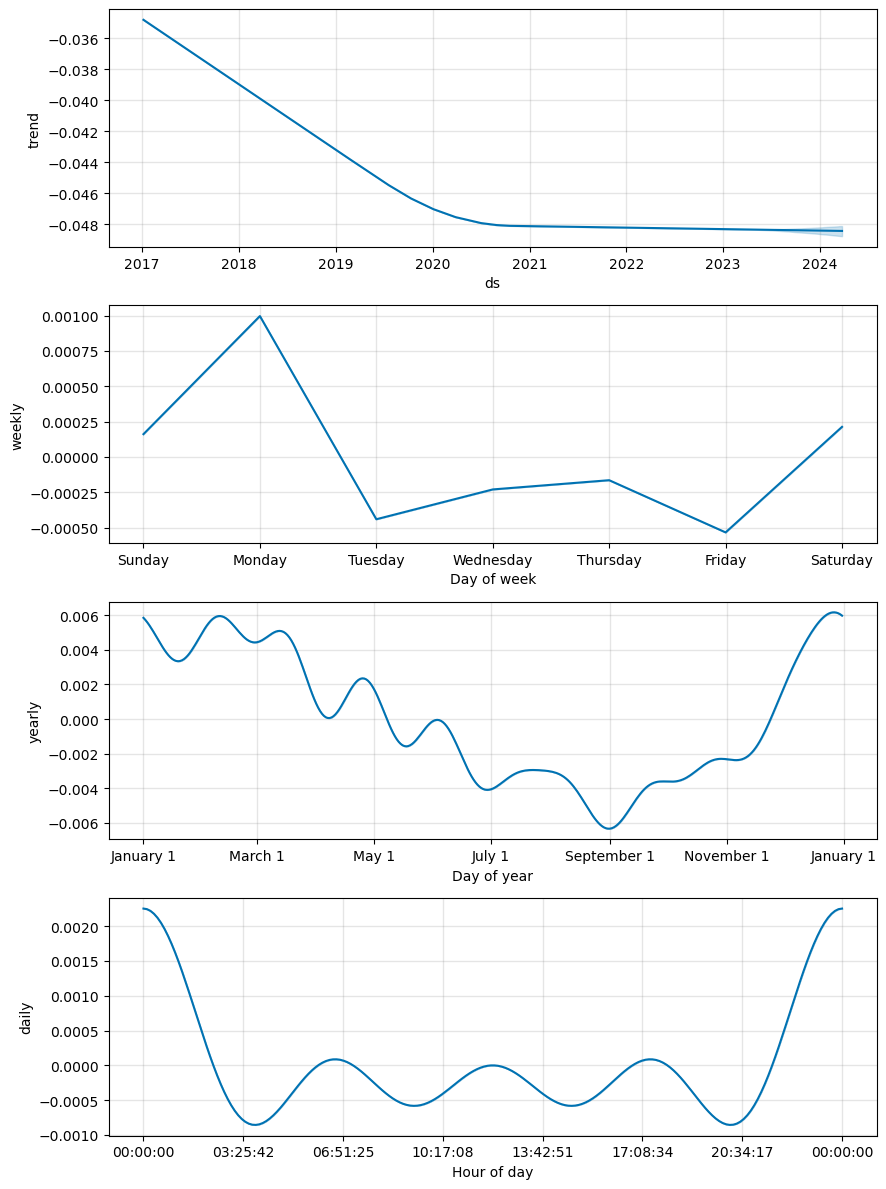

In [59]:
fig2 = m.plot_components(forecast)

## 1108

In [16]:
import ee
import pandas as pd

# Earth Engine API 초기화
ee.Initialize()

# GeoJSON 구조를 사용하여 AOI 설정
aoi = ee.Geometry.Polygon(
    [[[126.19653266055587, 36.853168924185226],
      [126.19653266055587, 36.83836240145186],
      [126.21259510596076, 36.83836240145186],
      [126.21259510596076, 36.853168924185226],
      [126.19653266055587, 36.853168924185226]]]
)

# 기간 설정 및 Sentinel-1 데이터 가져오기
start_date = '2017-01-01'
end_date = '2023-03-31'

# Sentinel-1 ImageCollection 필터링
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# RVI 계산 및 시계열 데이터 생성 함수
def calculate_rvi(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    vv = image.select('VV')
    vh = image.select('VH')
    rvi = vh.multiply(4).divide(vv.add(vh))
    mean_rvi = rvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10
    ).get('VH')
    return ee.Feature(None, {'ds': date, 'y': mean_rvi})

# 시계열 RVI 계산
time_series_rvi = sentinel1.map(calculate_rvi)

# 결과를 서버측 객체로 변환 (Python 클라이언트로 가져오기 위함)
rvi_features = time_series_rvi.getInfo()['features']

# 결과를 pandas DataFrame으로 변환
df = pd.DataFrame([feat['properties'] for feat in rvi_features])

# DataFrame을 'Date' 컬럼에 따라 오름차순으로 정렬
df = df.sort_values(by='ds')

# 정렬된 DataFrame 출력
print(df)



             ds         y
0    2017-02-24  2.392519
1    2017-03-08  2.372436
2    2017-03-20  2.371379
3    2017-04-01  2.356487
4    2017-04-13  2.375240
..          ...       ...
167  2023-02-05  2.415600
168  2023-02-17  2.403331
169  2023-03-01  2.393661
170  2023-03-13  2.403110
171  2023-03-25  2.392788

[174 rows x 2 columns]


In [17]:
df.describe()

,y
count,174.000000
mean,2.410218
std,0.029240
min,2.264821
25%,2.393034
50%,2.407969
75%,2.431514
max,2.473551


In [18]:
from prophet import Prophet
# Prophet 모델을 초기화하고 학습시킵니다.
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(df)

# 미래 날짜 프레임을 만들고 예측을 진행합니다.
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future) 

# 예측 결과를 가져옵니다.
forecasted_value = forecast.iloc[-1]['yhat']  # 예측된 값을 가져옴
print(f"Forecasted mean NDVI for the next period: {forecasted_value}")

# 예측 결과를 데이터프레임에 추가합니다.
forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)

# 결과 확인
print(forecast_df.tail())  # 마지막 5개의 결과를 출력합니다.

09:30:18 - cmdstanpy - INFO - Chain [1] start processing
09:30:18 - cmdstanpy - INFO - Chain [1] done processing


Forecasted mean NDVI for the next period: 2.419364346251185
                      ds         y
170           2023-02-17  2.403331
171           2023-03-01  2.393661
172           2023-03-13  2.403110
173           2023-03-25  2.392788
174  2024-03-24 00:00:00  2.419364


C:\Users\gunwo\AppData\Local\Temp\ipykernel_12340\2111206558.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)


In [28]:
import pandas as pd
from prophet import Prophet
import plotly.offline as py

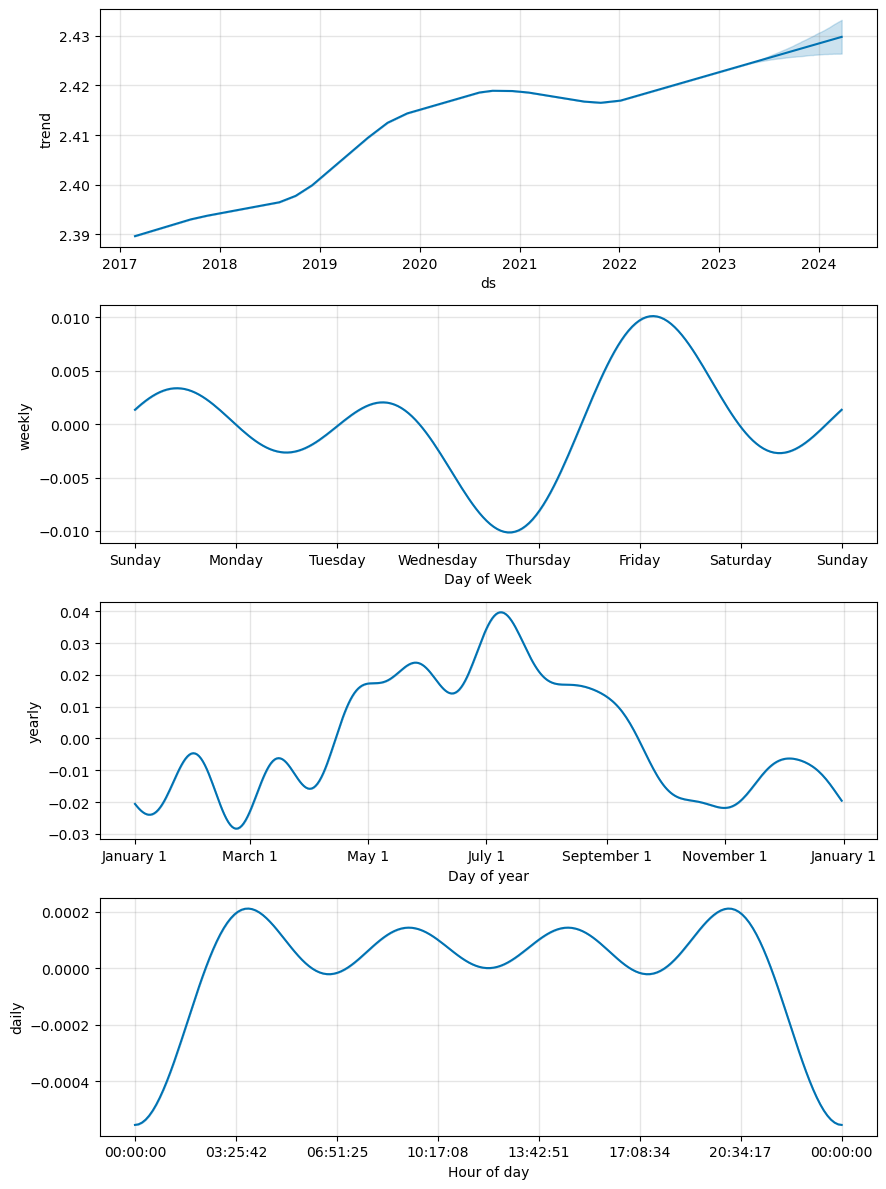

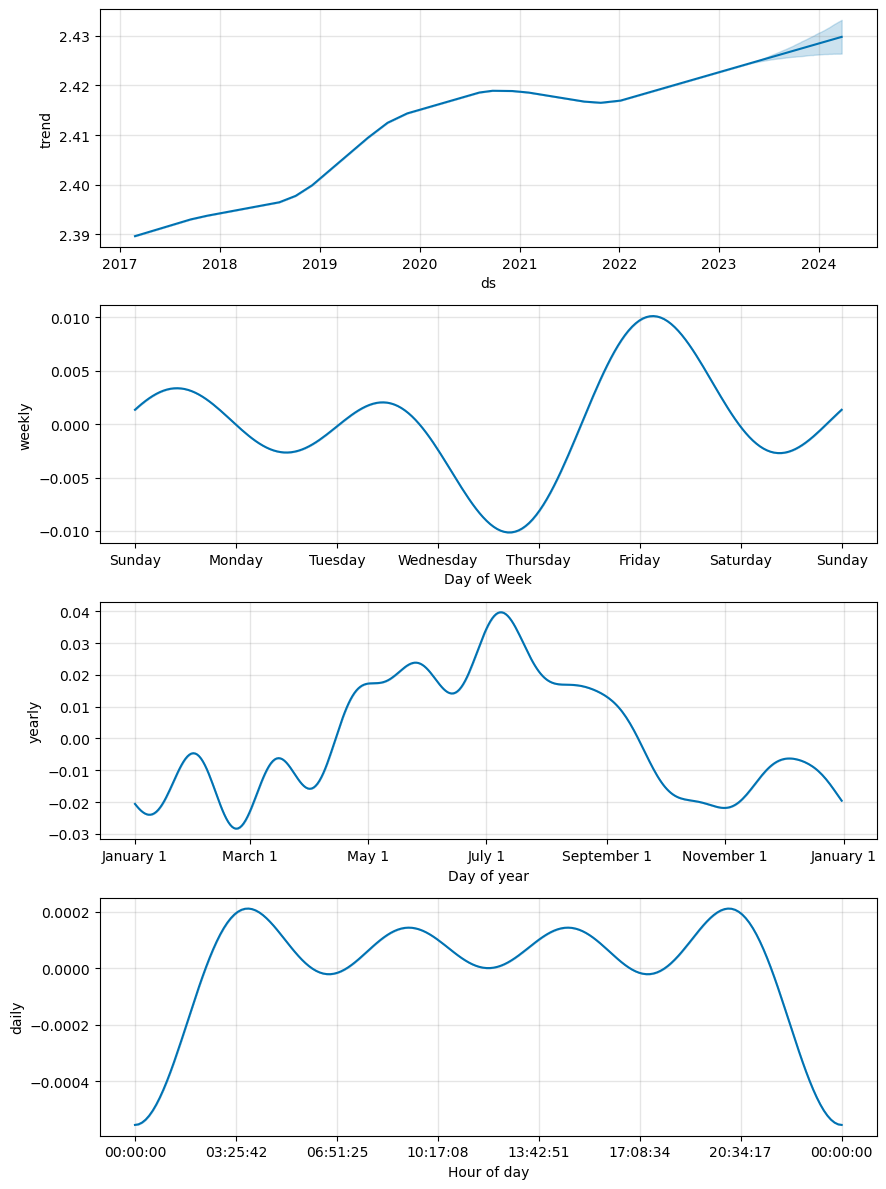

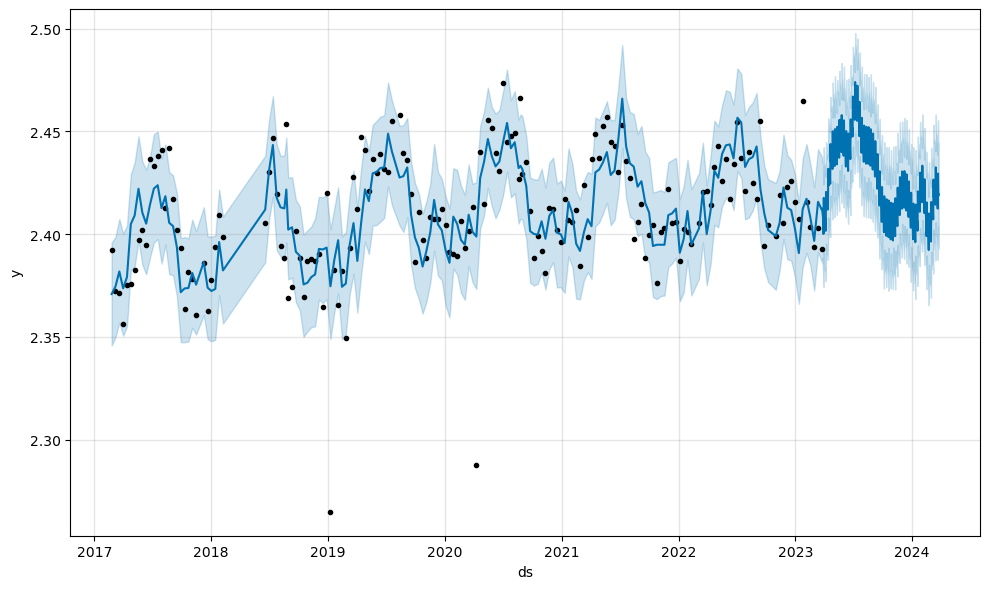

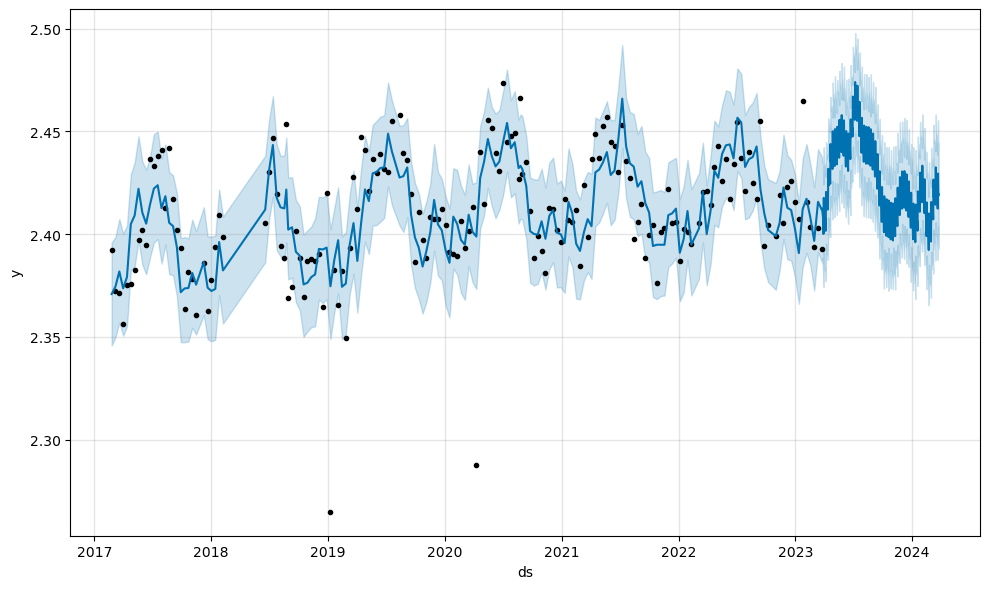

In [21]:
m.plot(forecast)

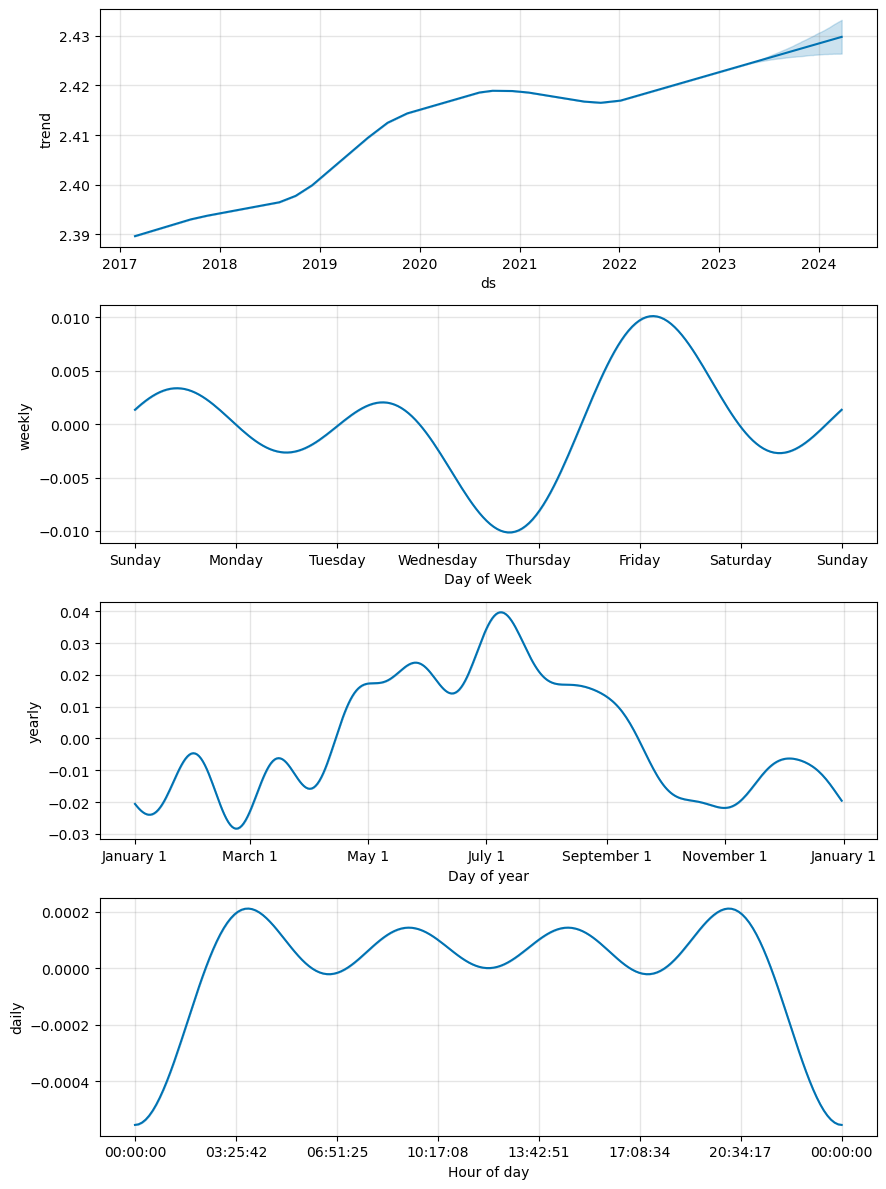

In [23]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assume `forecast` is your Prophet forecast dataframe and `m` is your fitted model
components = m.plot_components(forecast)

# Extract forecast components (you might need to adjust indices and column names based on your forecast dataframe)
trend = forecast['trend']
weekly = forecast['weekly']
yearly = forecast['yearly']
ds = forecast['ds']

# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Plot the trend
fig.add_trace(go.Scatter(x=ds, y=trend, name='Trend'), row=1, col=1)

# Plot the weekly component
fig.add_trace(go.Scatter(x=ds, y=weekly, name='Weekly'), row=2, col=1)

# Plot the yearly component
fig.add_trace(go.Scatter(x=ds, y=yearly, name='Yearly'), row=3, col=1)

# Update layout if needed
fig.update_layout(title='Forecast Components')

# Show the plot
fig.show()


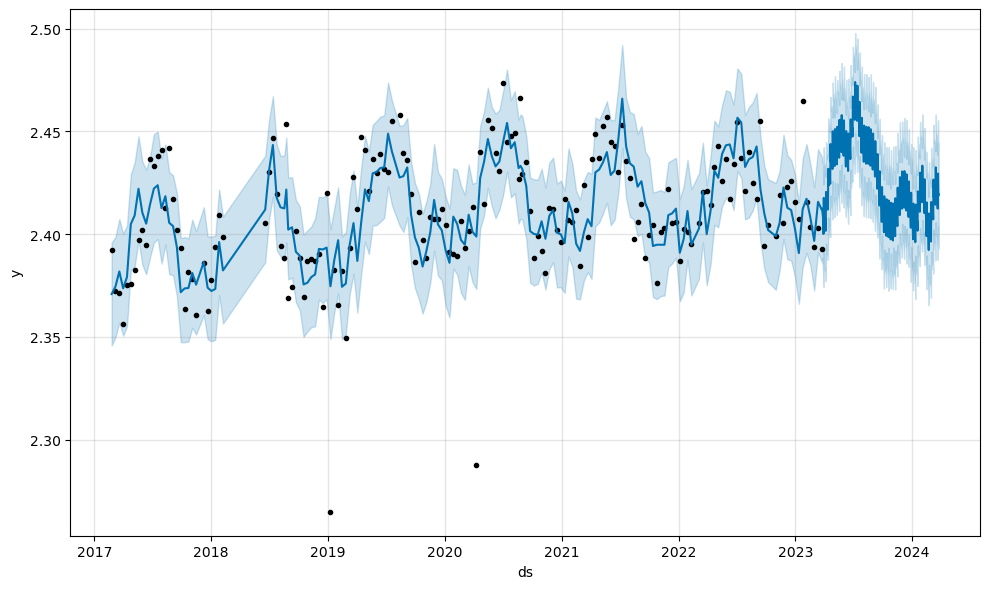

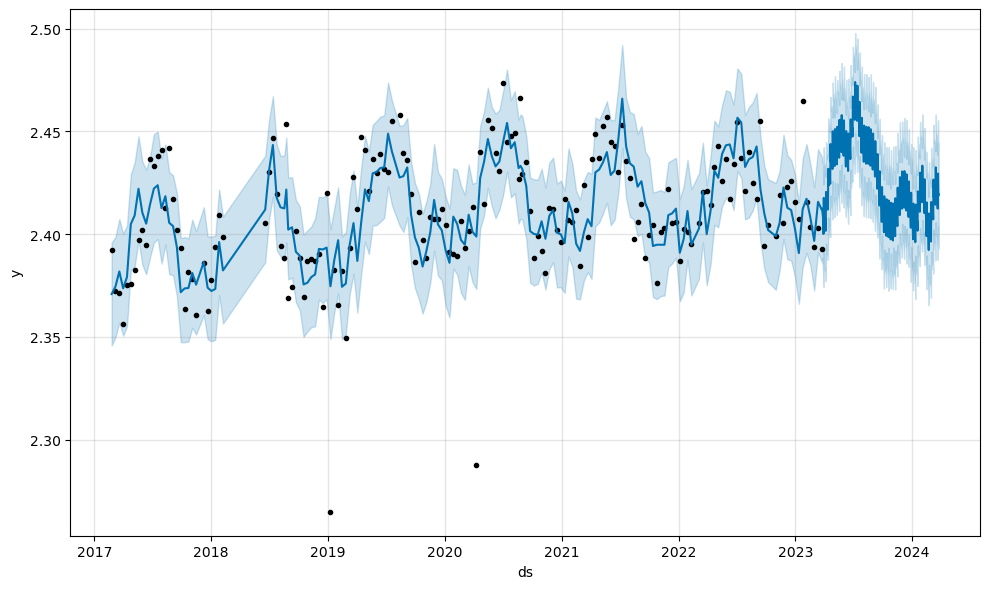

In [27]:
m.plot(forecast)

In [32]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [31]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [24]:
import plotly.graph_objs as go

# 예측 데이터프레임과 모델을 가정함, 'forecast'는 Prophet 예측 데이터프레임, 'm'는 피팅된 모델
fig = go.Figure()

# 신뢰 구간 상한 추가
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', name='상한 신뢰 구간', line=dict(color='gray')))

# 신뢰 구간 하한 추가, 상한과 함께 영역을 채움
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', name='하한 신뢰 구간', line=dict(color='gray')))

# 관측치 추가
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['y'], name='관측치', mode='markers'))

# 레이아웃 설정
fig.update_layout(title='Prophet 예측 결과', xaxis_title='날짜', yaxis_title='값')

# 그래프 표시
fig.show()


KeyError: 'y'